In [1]:
import datetime

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from itertools import product

from loading_utils import (_process_metadata, 
                           _process_training_curves, 
                           _process_testing_curves, 
                           _process_traning_forecasts, 
                           _process_testing_forecasts)

from ffc_utils import _fknn_forecast_dynamic_update

from functional_utils import (_confidence_intervals_from_eCDF,
                              _confidence_intervals_from_depth, 
                              _confidence_intervals_from_DQ)

from scores_utils import (_empirical_coverage_score,
                          _weighted_empirical_interval_score)

from viz_utils import (_plot_forecast_parameters, 
                       _plot_fneighborhood,
                       _plot_scenario_filtering, 
                       _plot_distance_histogram,
                       _plot_dates_histogram, 
                       _plot_forecasts,
                       _plot_scenarios,
                       _plot_updates, 
                       _plot_density_heatmap, 
                       _plot_histogram_cuts, 
                       _selected_scenarios_heatmap, 
                       _plot_frequency_map, 
                       _plot_envelop)

path_to_fDepth     = '/home/gterren/dynamic_update/functional_forecast_dynamic_update/fDepth'
path_to_data       = '/home/gterren/dynamic_update/data'
path_to_validation = '/home/gterren/dynamic_update/validation'

# Loading color palette
palette_ = pd.read_csv(path_to_data + "/palette.csv")
print(palette_)

# Loading Texas map
TX_ = gpd.read_file(path_to_data + "/maps/TX/State.shp")

      miro      ibm
0  #013396  #648FFF
1  #B1C06E  #785EF0
2  #056534  #DC267F
3  #F80202  #FE6100
4  #FDD906  #FFB000
5  #FCF795      NaN
6  #CCEDFF      NaN
7  #FDD60B      NaN
8  #FCE9D0      NaN


In [2]:
# Timestamps in interval
T = 288

# Loading and processing of sites metadata
meta_ = _process_metadata(file_name = '/wind_meta.xlsx', 
                          path      = path_to_data)
assets_ = meta_.index
X_tr_   = meta_[['lon', 'lat']].to_numpy()
print(X_tr_.shape)

meta_      = meta_.reset_index(drop = False)
vals, idx_ = np.unique(X_tr_, return_index = True, axis = 0)
assets_    = assets_[idx_]
X_tr_      = X_tr_[idx_, :]
print(assets_.shape)

idx_       = np.argsort(assets_)
assets_    = assets_[idx_]
X_tr_      = X_tr_[idx_, :]
print(assets_.shape)

# Loading and processing of historical curves for the training dataset
F_tr_, T_tr_, x_tr_, p_ = _process_training_curves(X_tr_, assets_, T,
                                                   file_name = '/actuals/wind_actual_5min_site_2017.csv',
                                                   path      = path_to_data)
print(F_tr_.shape, T_tr_.shape, x_tr_.shape, p_.shape)

# Loading and processing of historical curves for the testing dataset
F_ts_, T_ts_, x_ts_ = _process_testing_curves(X_tr_, assets_, p_, T,
                                              file_name = '/actuals/wind_actual_5min_site_2018.csv',
                                              path      = path_to_data)
print(F_ts_.shape, T_ts_.shape, x_ts_.shape)

# Loading and processing of historical day-ahead forecast for the training dataset
E_tr_ = _process_traning_forecasts(assets_, p_, T, 
                                   file_name = '/actuals/wind_day_ahead_forecast_2017.csv',
                                   path      = path_to_data)
print(E_tr_.shape)

# Loading and processing of historical day-ahead forecast for the testing dataset
E_ts_ = _process_testing_forecasts(assets_, p_, T,
                                   file_name = '/actuals/wind_day_ahead_forecast_2018.csv', 
                                   path      = path_to_data)
print(E_ts_.shape)

dt_ = np.array([t*5 for t in range(T)])
dx_ = pd.to_datetime(pd.DataFrame({'time': dt_}).time, unit = 'm').dt.strftime('%H:%M').to_numpy()
print(dt_.shape, dx_.shape)

t_tr_ = np.array([datetime.datetime.strptime(t_tr, '%Y-%m-%d').timetuple().tm_yday for t_tr in T_tr_]) - 1
t_ts_ = np.array([datetime.datetime.strptime(t_ts, '%Y-%m-%d').timetuple().tm_yday for t_ts in T_ts_])
print(t_tr_.shape, t_ts_.shape)

(264, 2)
(187,)
(187,)
(67881, 288) (67881,) (67881, 2) (187,)
(365, 288, 187) (365,) (187, 2)
(67881, 288)
(365, 288, 187)
(288,) (288,)
(67881,) (365,)


In [6]:
# Significance levels for the confidence intervals
alpha_ = [0.1, 0.2, 0.3, 0.4]

# Hyperparameters for the functional forecast dynamic update
forget_rate_f_  = [3.]
forget_rate_e_  = [.25]
length_scale_f_ = [0.005]   
length_scale_e_ = [0.5]
lookup_rate_    = [64]
trust_rate_     = [3]
nu_             = [8]
gamma_          = [140]
xi_             = [0.5]
kappa_min_      = [250]
kappa_max_      = [2000]

params_ = tuple(product(forget_rate_f_, 
                        forget_rate_e_, 
                        length_scale_f_,
                        length_scale_e_,
                        lookup_rate_, 
                        trust_rate_, 
                        nu_,
                        gamma_,
                        xi_, 
                        kappa_min_, 
                        kappa_max_))[0]

asset = 2
day   = 1
time  = 144

t1 = datetime.datetime.now()

file_name = f'{asset}-{day}-{time}'
print(params_, file_name)

f_     = F_ts_[day, :time, asset]
e_     = E_ts_[day, :, asset]
x_     = x_ts_[asset, :]
t      = t_ts_[day]
f_hat_ = F_ts_[day, time:, asset]

# Get time constants
tau_ = dt_[:time]
s_   = dt_[time:]

_model, M_, status = _fknn_forecast_dynamic_update(F_tr_, E_tr_, x_tr_, t_tr_, dt_, f_, e_, x_, t,
                                                   forget_rate_f  = params_[0],
                                                   forget_rate_e  = params_[1],
                                                   length_scale_f = params_[2],
                                                   length_scale_e = params_[3],
                                                   lookup_rate    = params_[4],
                                                   trust_rate     = params_[5],
                                                   nu             = params_[6],
                                                   gamma          = params_[7],
                                                   xi             = params_[8],
                                                   kappa_min      = params_[9],
                                                   kappa_max      = params_[10])

f_tau_rmse = np.sqrt(np.mean((f_ - e_[:time])**2))
f_s_rmse   = np.sqrt(np.mean((np.median(M_, axis = 0) - e_[time:])**2))
print(f_tau_rmse, f_s_rmse)

# Calculate marginal empirical confidence intervals
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)
WIS                = _weighted_empirical_interval_score(f_hat_, m_, _lower, _upper, alpha_)
CS_                = _empirical_coverage_score(f_hat_, _lower, _upper, alpha_)

t2 = datetime.datetime.now()
print(t2 - t1)

(3.0, 0.25, 0.005, 0.5, 64, 3, 8, 140, 0.5, 250, 2000) 2-1-144
(2976,) (2480,) (2015,) (2015,)
0.02263148509695308 0.12215034590642057
0:00:00.466147


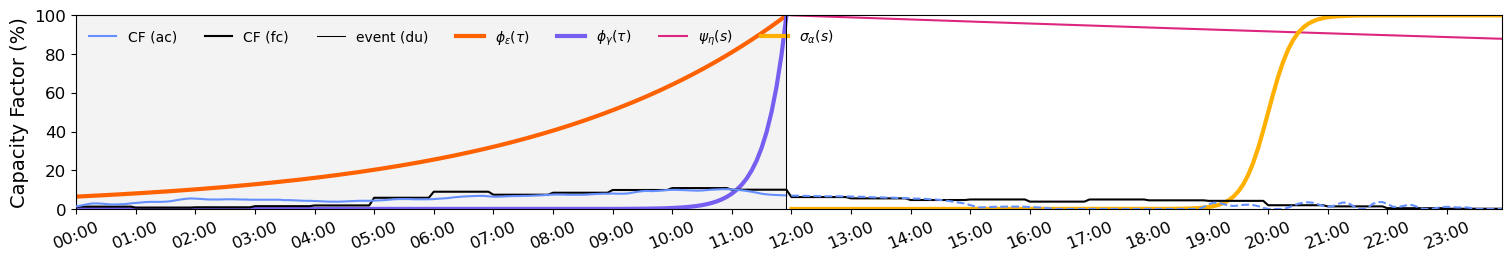

In [11]:
_fig, _ax = plt.subplots(1, 1, 
                         figsize = (15, 2.5), 
                         layout = "constrained")

_plot_forecast_parameters(_ax, palette_, f_, e_, f_hat_, _model['phi'], _model['psi'], _model['eta'], dx_, dt_, time)

# plt.savefig(path_to_images + r"/parameters.png", 
#             bbox_inches = "tight", 
#             dpi = 300)

plt.show()

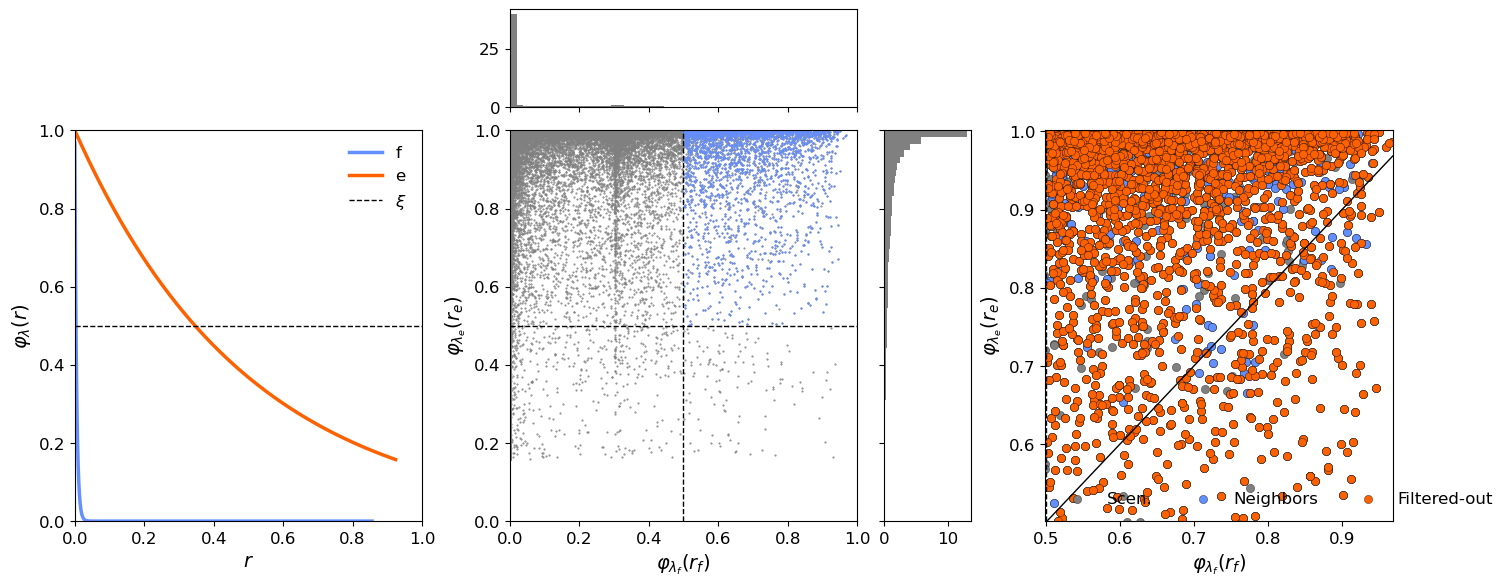

In [12]:
_fig, _ax = plt.subplot_mosaic([[".", ".", "c", ".", ".", "."],
                                ["a", "a", "b", "d", "e", "e"],
                                ["a", "a", "b", "d", "e", "e"]],
                                figsize     = (15, 5.75),
                                layout      = "constrained",
                                gridspec_kw = dict(width_ratios  = (2, 2, 4, 1, 2, 2), 
                                                   height_ratios = (1, 2, 2)))

_plot_fneighborhood(_ax, palette_, _model['d_f'], _model['d_e'], _model['w_f'], 
                    _model['w_e'], _model['w'], _model['idx_1'], _model['idx_2'], _model['idx_3'], params_[8])

# plt.savefig(path_to_images + r"/fneighbor.png", 
#             bbox_inches="tight", 
#             dpi=300)

plt.show()

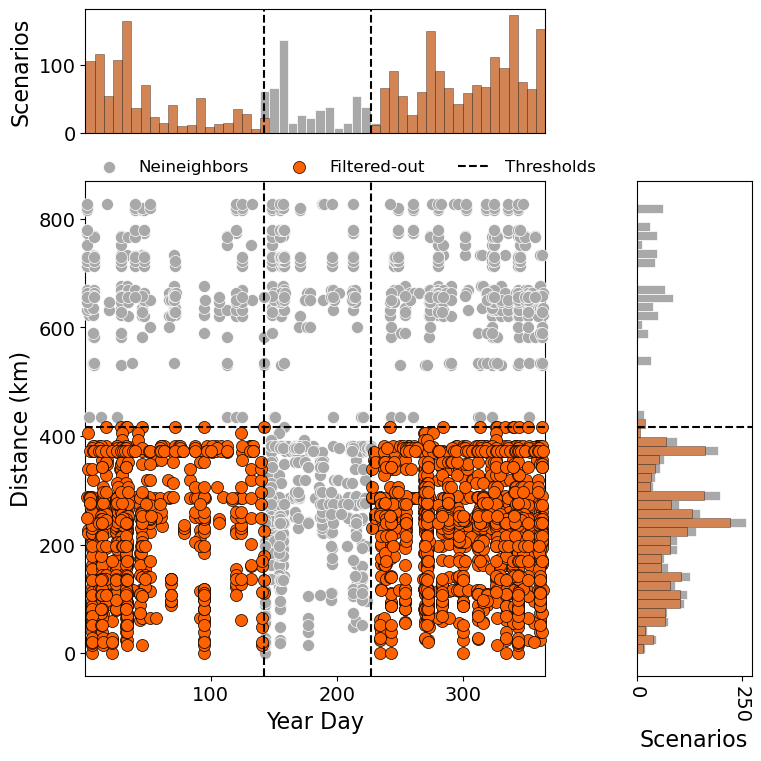

In [13]:
_fig, _ax = plt.subplot_mosaic([["a", "."], 
                                ["b", "c"]],
                                figsize     = (7.5, 7.5),
                                layout      = "constrained",
                                gridspec_kw = dict(width_ratios = (1, .25), 
                                                   height_ratios = (.25, 1)))

_plot_dates_histogram(_ax["a"], palette_, t_tr_, _model['idx_1'], _model['idx_2'], t, _model['Gamma'], _model['gamma'])

_plot_scenario_filtering(
    _ax["b"], palette_, _model['d_h'], t_tr_, _model['idx_1'], _model['idx_3'], t, 
    _model['Gamma'], _model['gamma'], _model['sigma'])

_plot_distance_histogram(_ax["c"], palette_, _model['d_h'], _model['idx_1'], _model['idx_3'])

_ax["b"].legend(frameon=False, 
                ncol=3, 
                loc = (0., 1.), 
                fontsize = 12)

# plt.savefig(path_to_images + r"/frequency_mosaic.png", 
#             bbox_inches="tight", 
#             dpi=600)

plt.show()

(144,) (144,) (144,)


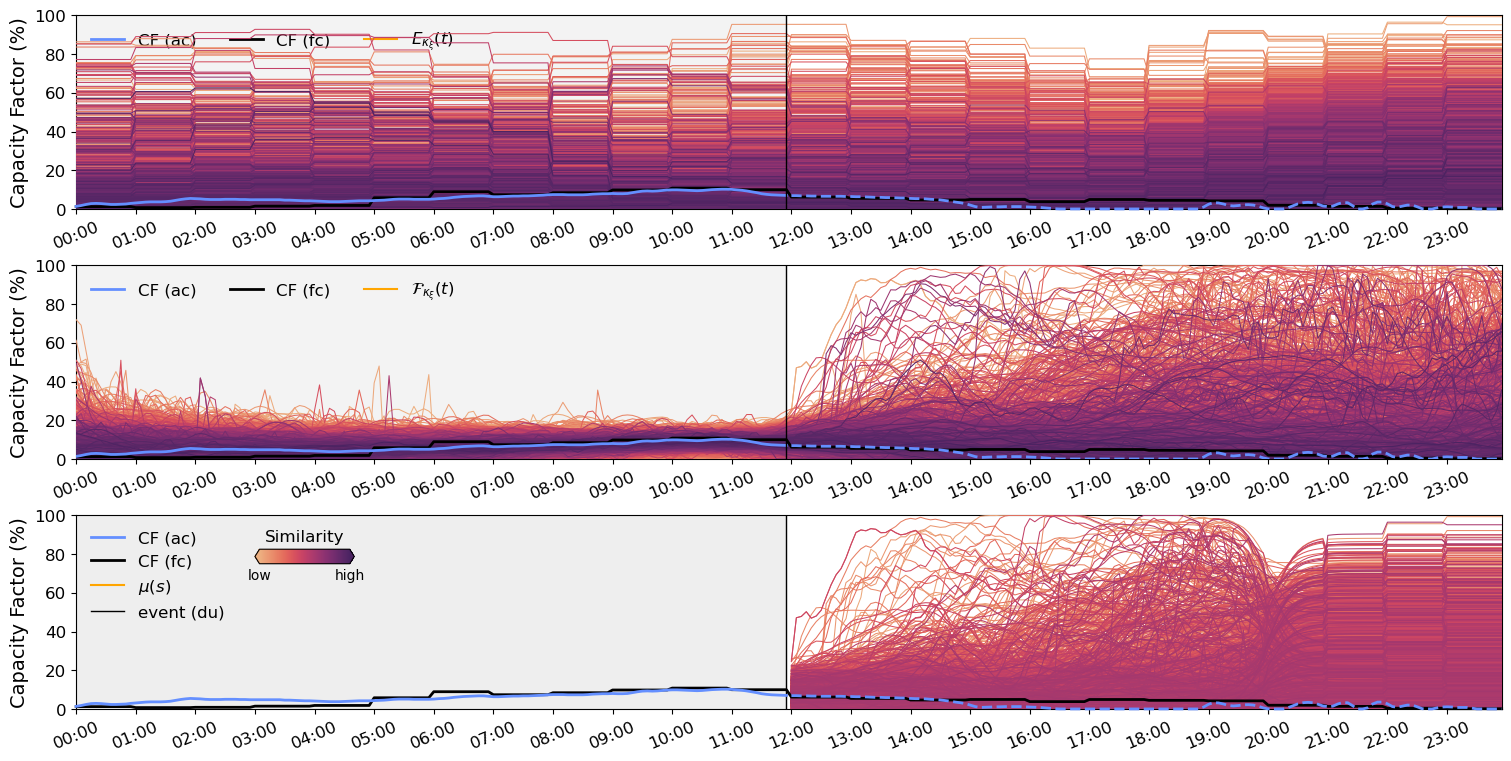

In [6]:
_fig, _ax = plt.subplot_mosaic([["a"], ["b"], ["c"]],
                               figsize=(15, 7.5),
                               layout ="constrained")

_plot_forecasts(_ax["a"], palette_, E_tr_, f_, e_, f_hat_, _model['w'], _model['idx_2'], dx_, dt_, time)

_plot_scenarios(_ax["b"], palette_, F_tr_, f_, e_, f_hat_, _model['w'], _model['idx_2'], dx_, dt_, time)

_plot_updates(_fig, _ax["c"], palette_, M_, f_, e_, f_hat_, _model['w'], _model['idx_2'], dx_, dt_, time)

# plt.savefig(path_to_images + r"/scenarios_fc.png", 
#             bbox_inches="tight", 
#             dpi=300)

plt.show()

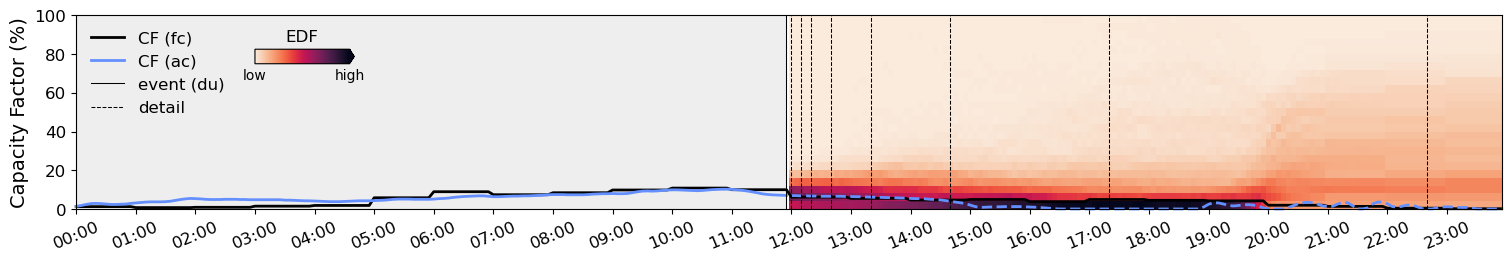

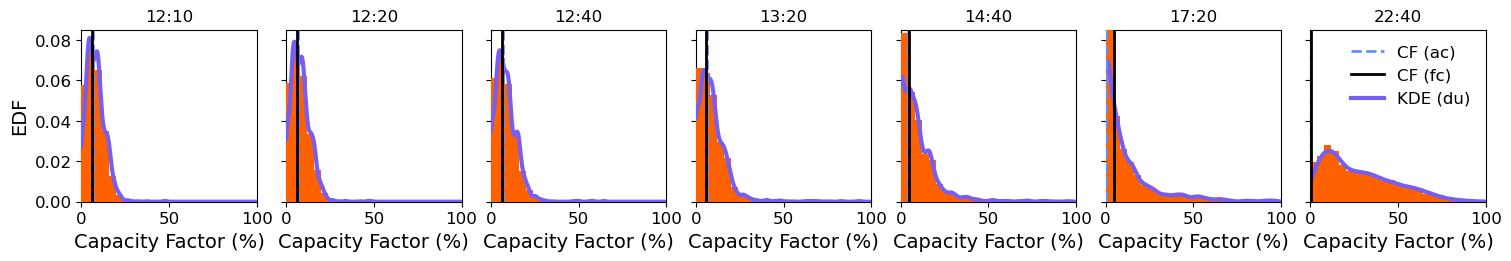

In [14]:
cuts_ = [2, 4, 8, 16, 32, 64, 128]

_fig, _ax = plt.subplots(1, 1, 
                         figsize=(15, 2.5), 
                         layout="constrained")

_plot_density_heatmap(_fig, _ax, palette_, M_, f_, e_, f_hat_, dx_, dt_, time, cuts_)

# plt.savefig(path_to_images + r"/eCDF_heatmap.pdf", 
#             bbox_inches="tight", 
#             dpi=300)

plt.show()

_fig, _ax = plt.subplots(1, len(cuts_), 
                         figsize=(15, 2.5), 
                         sharey=True, 
                         layout="constrained")

_plot_histogram_cuts(_ax, palette_, M_, e_, f_hat_, dx_, dt_, time, cuts_)

# plt.savefig(path_to_images + r"/hist_cutoffs.pdf", 
#             bbox_inches="tight", 
#             dpi=300)

plt.show()

2480 Jan


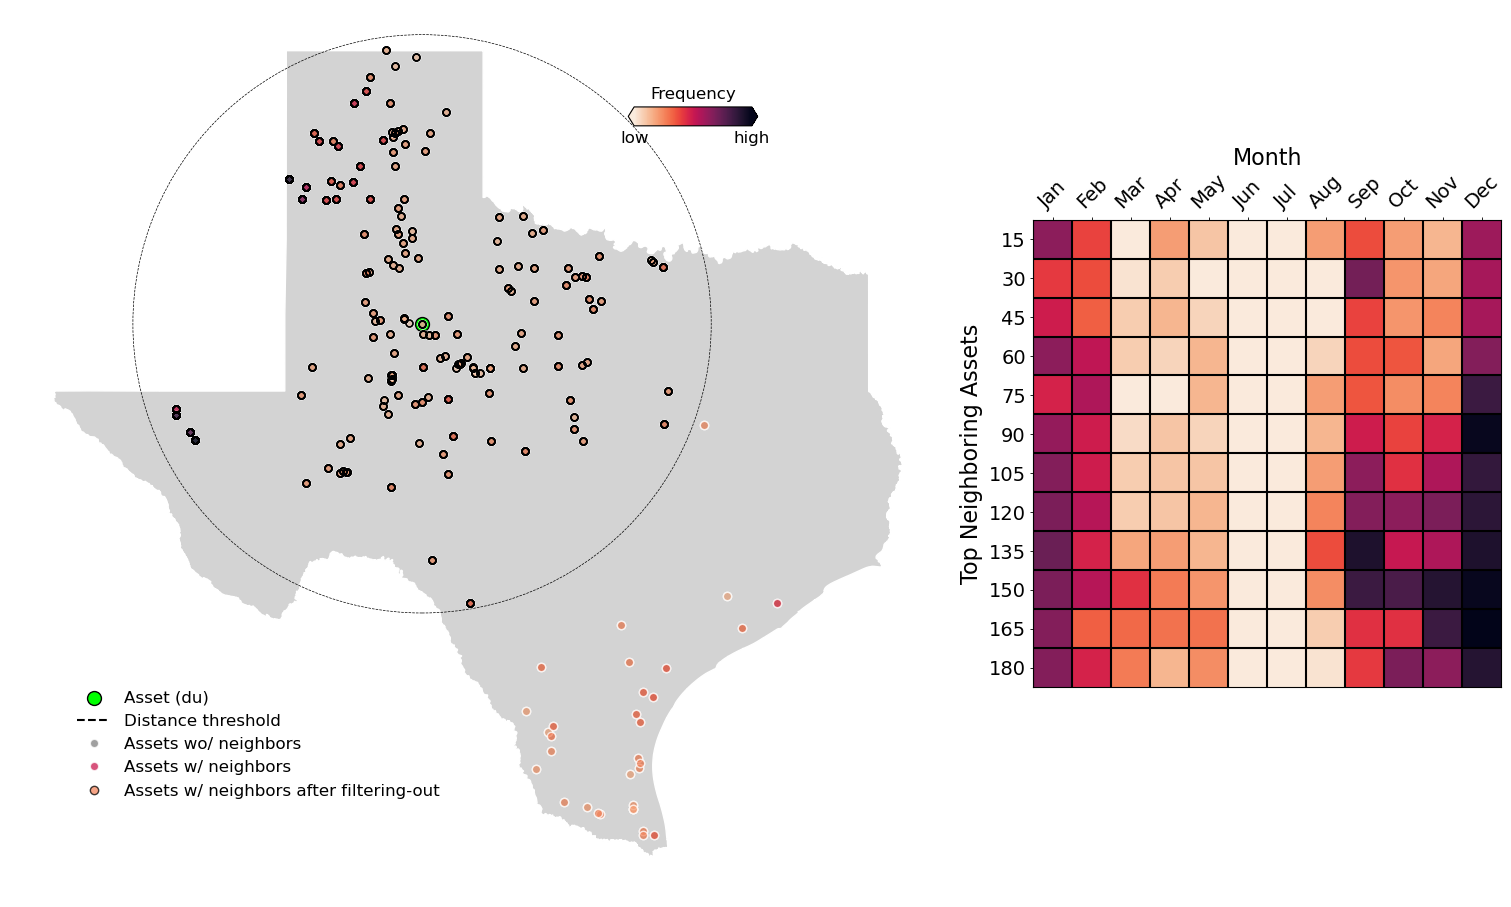

In [15]:
fig, _ax = plt.subplot_mosaic([["a", "b"]],
                              figsize     = (15, 10),
                              layout      = "constrained",
                              gridspec_kw = dict(width_ratios = (2, 1)))

_plot_frequency_map(_fig, _ax["a"], TX_, x_tr_, x_ts_, x_, _model['idx_2'], _model['idx_3'], _model['sigma'])
_selected_scenarios_heatmap(_ax["b"], T_tr_, _model['d_h'], x_ts_, x_, _model['idx_2'], T_ts_[day])

# plt.savefig(path_to_images + r"/frequency_mosaic.pdf", 
#             bbox_inches="tight", 
#             dpi=600)

plt.show()

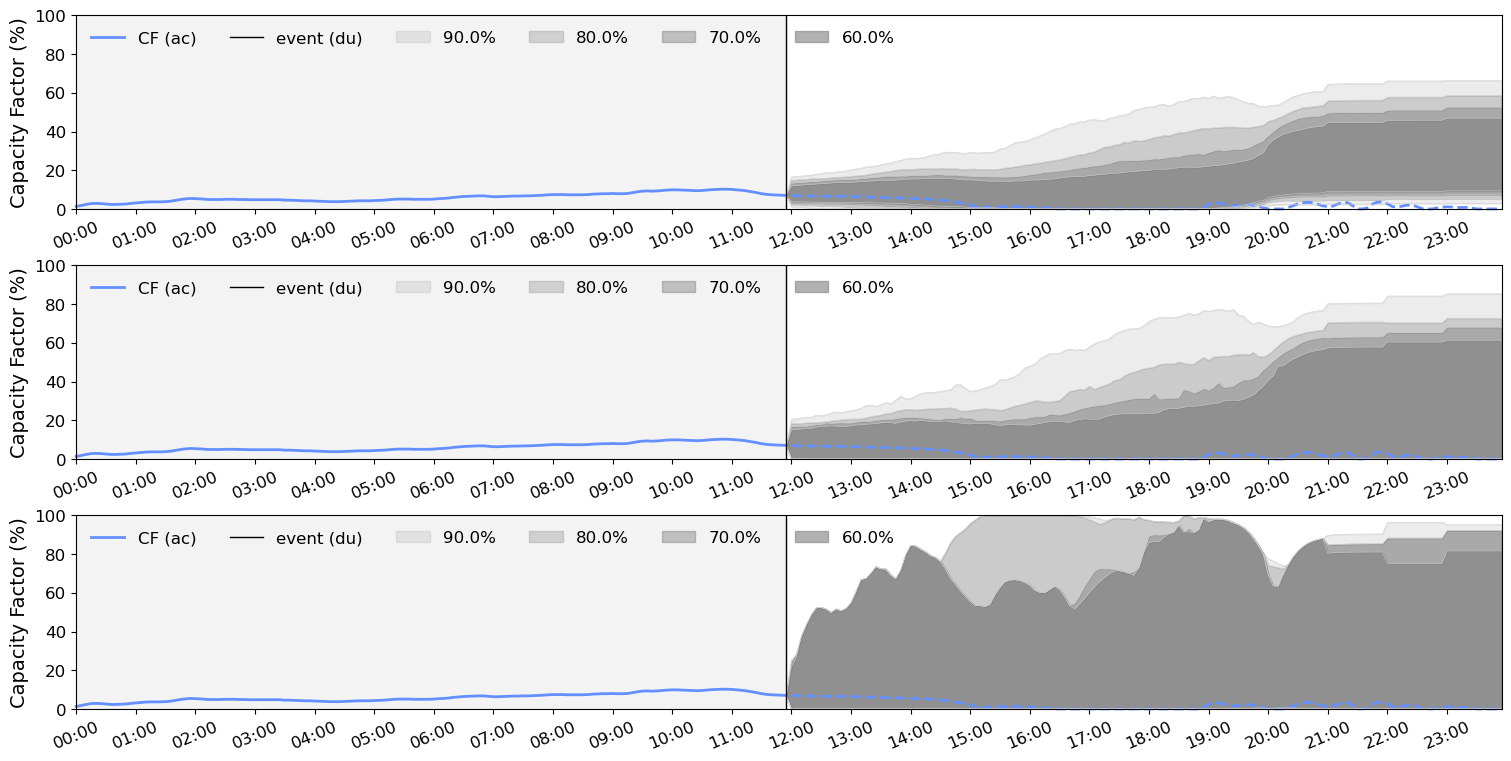

In [4]:
fig, _ax = plt.subplot_mosaic([["a"], ["b"], ["c"]],
                              figsize = (15, 7.5),
                              layout  = "constrained")

alpha_ = [0.1, 0.2, 0.3, 0.4]
    
# Calculate confidence intervals from functional depth metrics
m_, _upper, _lower = _confidence_intervals_from_eCDF(M_, alpha_)

_plot_envelop(_ax["a"], palette_, _upper, _lower, f_, f_hat_, dt_, dx_, tau_, s_, time)

# Calculate confidence intervals from Directional Quantiles
m_, _upper, _lower = _confidence_intervals_from_DQ(M_, alpha_)

_plot_envelop(_ax["b"], palette_, _upper, _lower, f_, f_hat_, dt_, dx_, tau_, s_, time)

# Calculate confidence intervals from the functional depth metric
m_, _upper, _lower = _confidence_intervals_from_depth(M_, alpha_)

_plot_envelop(_ax["c"], palette_, _upper, _lower, f_, f_hat_, dt_, dx_, tau_, s_, time)

# plt.savefig(path_to_images + r"/fEnvelop.pdf", 
#             bbox_inches="tight", 
#             dpi=600)

plt.show()